# BaarleNet [Part 6 - Scale up Width].ipynb

In [1]:
import numpy as np
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import torch.optim as optim
import cv2
from matplotlib.gridspec import GridSpec
from tqdm import tqdm
import os

In [31]:
def denorm(p, size=960):
    result = np.zeros_like(p)
    result[..., 0] = (p[..., 0] + 1) * (size / 2)
    result[..., 1] = size - ((p[..., 1] + 1) * (size / 2))
    return result

def get_relu_joint(weight_1, weight_2, bias, extent=1):
    if np.abs(weight_2) < 1e-8: 
        x_intercept = -bias / weight_1
        return [[x_intercept, -extent], [x_intercept, extent]] if -extent <= x_intercept <= extent else []
    elif np.abs(weight_1) < 1e-8:
        y_intercept = -bias / weight_2
        return [[-extent, y_intercept], [extent, y_intercept]] if -extent <= y_intercept <= extent else []
    else:
        points = []
        for x in [-extent, extent]:
            y = (-x * weight_1 - bias) / weight_2
            if -extent <= y <= extent: points.append([x, y])
        for y in [-extent, extent]:
            x = (-y * weight_2 - bias) / weight_1
            if -extent <= x <= extent: points.append([x, y])
        unique_points = []
        for p in points:
            is_duplicate = False
            for existing in unique_points:
                if abs(p[0] - existing[0]) < 1e-8 and abs(p[1] - existing[1]) < 1e-8:
                    is_duplicate = True
                    break
            if not is_duplicate:
                unique_points.append(p)
        return unique_points

def viz_map_with_predictions(ax, map, X, y):
    probe=np.zeros((100,100,2))
    for j, xx in enumerate(np.linspace(-1, 1, 100)):
        for k, yy in enumerate(np.linspace(-1, 1, 100)):
            probe[j, k]=[yy,xx]
    probe=probe.reshape(100**2, -1)
    probe_logits=model(torch.tensor(probe).float())
    probe_logits=probe_logits.detach().numpy().reshape(100,100,2)
    probe_softmax = torch.nn.Softmax(dim=1)(torch.tensor(probe_logits.reshape(-1, 2)))
    
    ax.imshow(map.mean(2), cmap='gray')
    ax.imshow(np.flipud(probe_softmax[:,1].reshape(100, 100)), 
               extent=[0, 960, 960, 0],  # This maps to image coordinates
               alpha=0.7,
               cmap='viridis')
    
    X_denorm=denorm(X[:1000,:])
    # plt.scatter(X_denorm[:,0], X_denorm[:,1], c=y[:1000], s=2, alpha=0.8)
    labels=y[:1000]
    y_hat=torch.argmax(model(torch.tensor(X[:1000,:]).float()).detach(),1).numpy()
    tp_mask=np.logical_and(labels==1, y_hat==1)
    fp_mask=np.logical_and(labels==0, y_hat==1)
    fn_mask=np.logical_and(labels==1, y_hat==0)
    tn_mask=np.logical_and(labels==0, y_hat==0)
    ax.scatter(X_denorm[tp_mask,0], X_denorm[tp_mask,1], c='g', s=3, alpha=0.8)
    ax.scatter(X_denorm[fp_mask,0], X_denorm[fp_mask,1], c='r', marker='x', s=5, alpha=0.8)
    ax.scatter(X_denorm[fn_mask,0], X_denorm[fn_mask,1], c='orange', marker='x', s=5, alpha=0.8)
    ax.scatter(X_denorm[tn_mask,0], X_denorm[tn_mask,1], c='purple', marker='o', s=5, alpha=0.8)

def extract_weights_to_numpy(model, layer_indices=None, output_file=None):
    """
    Extract PyTorch model weights and biases to NumPy arrays with copy-paste ready code.
    
    Args:
        model: PyTorch model
        layer_indices: List of layer indices to extract (if None, extracts all layers with weights)
        output_file: Optional file path to save the output code
    
    Returns:
        String containing the NumPy array definitions ready to copy-paste
    """
    
    lines = []
    lines.append("import numpy as np\n")
    
    # Auto-detect layers if not specified
    if layer_indices is None:
        layer_indices = []
        for i, layer in enumerate(model.model):
            if hasattr(layer, 'weight'):
                layer_indices.append(i)
    
    # Extract weights and biases
    weight_counter = 1
    for idx in layer_indices:
        layer = model.model[idx]
        
        if hasattr(layer, 'weight'):
            # Extract weight
            weight_np = layer.weight.detach().numpy()
            weight_repr = np.array2string(weight_np, 
                                        separator=', ', 
                                        formatter={'float_kind': lambda x: f"{x:g}"})
            lines.append(f"w{weight_counter} = np.array({weight_repr}, dtype=np.float32)")
            
            # Extract bias if it exists
            if hasattr(layer, 'bias') and layer.bias is not None:
                bias_np = layer.bias.detach().numpy()
                bias_repr = np.array2string(bias_np, 
                                          separator=', ', 
                                          formatter={'float_kind': lambda x: f"{x:g}"})
                lines.append(f"b{weight_counter} = np.array({bias_repr}, dtype=np.float32)")
            
            weight_counter += 1
    
    output = '\n'.join(lines)
    
    # Save to file if specified
    if output_file:
        with open(output_file, 'w') as f:
            f.write(output)
        print(f"Weights saved to {output_file}")
    
    # Print to console
    print(output)
    return output

def extract_specific_layers(model, layer_specs):
    """
    Extract specific layers with custom naming.
    
    Args:
        model: PyTorch model
        layer_specs: List of tuples (layer_index, weight_name, bias_name)
                    e.g., [(0, 'w1', 'b1'), (2, 'w2', 'b2')]
    
    Returns:
        String containing the NumPy array definitions
    """
    
    lines = []
    lines.append("import numpy as np\n")
    
    for layer_idx, weight_name, bias_name in layer_specs:
        layer = model.model[layer_idx]
        
        if hasattr(layer, 'weight'):
            # Extract weight
            weight_np = layer.weight.detach().numpy()
            weight_repr = np.array2string(weight_np, 
                                        separator=', ', 
                                        formatter={'float_kind': lambda x: f"{x:g}"})
            lines.append(f"{weight_name} = np.array({weight_repr}, dtype=np.float32)")
            
            # Extract bias if it exists and bias_name is provided
            if bias_name and hasattr(layer, 'bias') and layer.bias is not None:
                bias_np = layer.bias.detach().numpy()
                bias_repr = np.array2string(bias_np, 
                                          separator=', ', 
                                          formatter={'float_kind': lambda x: f"{x:g}"})
                lines.append(f"{bias_name} = np.array({bias_repr}, dtype=np.float32)")
    
    output = '\n'.join(lines)
    print(output)
    return output

In [3]:
def get_second_layer_boundaries(model, extent=1):
    """
    Analytically solve for second layer ReLU boundaries
    Returns list of line segments for each second layer neuron
    """
    
    # Get layer weights and biases
    W1 = model.model[0].weight.detach().numpy()  # Shape: (2, 2)
    b1 = model.model[0].bias.detach().numpy()    # Shape: (2,)
    W2 = model.model[2].weight.detach().numpy()  # Shape: (2, 2) 
    b2 = model.model[2].bias.detach().numpy()    # Shape: (2,)
    
    # First, get the first layer ReLU boundaries
    first_layer_boundaries = []
    for i in range(2):
        boundary = get_relu_joint(W1[i,0], W1[i,1], b1[i], extent)
        first_layer_boundaries.append(boundary)
    
    # Define the regions created by first layer boundaries
    # Each region is defined by which first layer neurons are active
    regions = [
        (False, False),  # Both neurons off
        (True, False),   # First neuron on, second off
        (False, True),   # First neuron off, second on  
        (True, True)     # Both neurons on
    ]
    
    second_layer_boundaries = []
    
    # For each second layer neuron
    for neuron_idx in range(2):
        neuron_boundaries = []
        
        # For each region defined by first layer
        for region_mask in regions:
            # In this region, the second layer pre-activation is:
            # h2_pre = W2[neuron_idx, 0] * (W1[0,:] * x + b1[0]) * region_mask[0] + 
            #          W2[neuron_idx, 1] * (W1[1,:] * x + b1[1]) * region_mask[1] + 
            #          b2[neuron_idx]
            
            # Collect active terms
            active_weight = np.zeros(2)  # Coefficients for [x, y]
            active_bias = b2[neuron_idx]
            
            for i in range(2):
                if region_mask[i]:  # If this first layer neuron is active
                    active_weight += W2[neuron_idx, i] * W1[i, :]
                    active_bias += W2[neuron_idx, i] * b1[i]
            
            # Now solve: active_weight[0] * x + active_weight[1] * y + active_bias = 0
            boundary = get_relu_joint(active_weight[0], active_weight[1], active_bias, extent)
            
            if boundary:
                # Check if this boundary segment is actually within the region
                # We need to verify that the boundary points satisfy the region constraints
                valid_segments = []
                
                for seg_start, seg_end in zip(boundary[:-1], boundary[1:]):
                    # Check if segment is within the region defined by first layer
                    # Sample a point in the middle of the segment
                    mid_point = [(seg_start[0] + seg_end[0])/2, (seg_start[1] + seg_end[1])/2]
                    
                    # Check if this point satisfies the region constraints
                    point_in_region = True
                    for i in range(2):
                        first_layer_activation = W1[i,0] * mid_point[0] + W1[i,1] * mid_point[1] + b1[i]
                        is_active = first_layer_activation > 0
                        if is_active != region_mask[i]:
                            point_in_region = False
                            break
                    
                    if point_in_region:
                        valid_segments.append([seg_start, seg_end])
                
                neuron_boundaries.extend(valid_segments)
        
        second_layer_boundaries.append(neuron_boundaries)
    
    return second_layer_boundaries

def plot_second_layer_boundaries_analytical(ax, model):
    """Plot analytically computed second layer boundaries"""
    
    boundaries = get_second_layer_boundaries(model)
    
    colors = ['red', 'blue']
    for neuron_idx, neuron_boundaries in enumerate(boundaries):
        for segment in neuron_boundaries:
            if len(segment) == 2:  # Valid line segment
                seg_denorm = denorm(np.array(segment))
                ax.plot([seg_denorm[0][0], seg_denorm[1][0]], 
                       [seg_denorm[0][1], seg_denorm[1][1]], 
                       color=colors[neuron_idx], linewidth=2, alpha=0.8,
                       linestyle='dashed', label=f'Layer 2 Neuron {neuron_idx}')

# Simpler version that focuses on the boundary intersections
def get_second_layer_boundaries_simple(model, extent=1):
    """
    Simplified approach: compute boundary in each quadrant defined by first layer
    """
    W1 = model.model[0].weight.detach().numpy()
    b1 = model.model[0].bias.detach().numpy()
    W2 = model.model[2].weight.detach().numpy()
    b2 = model.model[2].bias.detach().numpy()
    
    boundaries = []
    
    # For each second layer neuron
    for neuron_idx in range(2):
        neuron_boundaries = []
        
        # Sample points in a grid and find where the second layer neuron crosses zero
        # But do it analytically by solving the piecewise linear equation
        
        # The key insight: in each region, the equation is linear
        # Region 1: both first layer neurons off
        # h2 = b2[neuron_idx]
        # This gives no boundary unless b2[neuron_idx] = 0
        
        # Region 2: first neuron on, second off  
        # h2 = W2[neuron_idx,0] * (W1[0,0]*x + W1[0,1]*y + b1[0]) + b2[neuron_idx]
        # Set to 0 and solve for the line
        if True:  # Always try this region
            w_eff = W2[neuron_idx, 0] * W1[0, :]
            b_eff = W2[neuron_idx, 0] * b1[0] + b2[neuron_idx]
            boundary = get_relu_joint(w_eff[0], w_eff[1], b_eff, extent)
            if boundary:
                neuron_boundaries.append(boundary)
        
        # Region 3: first neuron off, second on
        if True:
            w_eff = W2[neuron_idx, 1] * W1[1, :]
            b_eff = W2[neuron_idx, 1] * b1[1] + b2[neuron_idx]
            boundary = get_relu_joint(w_eff[0], w_eff[1], b_eff, extent)
            if boundary:
                neuron_boundaries.append(boundary)
        
        # Region 4: both neurons on
        if True:
            w_eff = W2[neuron_idx, 0] * W1[0, :] + W2[neuron_idx, 1] * W1[1, :]
            b_eff = W2[neuron_idx, 0] * b1[0] + W2[neuron_idx, 1] * b1[1] + b2[neuron_idx]
            boundary = get_relu_joint(w_eff[0], w_eff[1], b_eff, extent)
            if boundary:
                neuron_boundaries.append(boundary)
        
        boundaries.append(neuron_boundaries)
    
    return boundaries

# Usage:
def plot_all_boundaries(ax, model):
    """Plot both first and second layer boundaries"""
    
    # First layer (solid lines)
    for neuron_idx in range(2):
        w1 = model.model[0].weight[neuron_idx, 0].item()
        w2 = model.model[0].weight[neuron_idx, 1].item()
        b = model.model[0].bias[neuron_idx].item()
        
        joint = get_relu_joint(w1, w2, b, extent=1)
        if joint:
            joint_denorm = denorm(np.array(joint))
            ax.plot([joint_denorm[0][0], joint_denorm[1][0]], 
                   [joint_denorm[0][1], joint_denorm[1][1]], 
                   color=f'C{neuron_idx}', linewidth=2, alpha=0.8,
                   label=f'Layer 1 Neuron {neuron_idx}')
    
    # Second layer (dashed lines)
    plot_second_layer_boundaries_analytical(ax, model)

In [4]:
map=cv2.imread('Baarle-Nassau_-_Baarle-Hertog-en no legend.png')[:,:,(2,1,0)]

belgium_color=np.array([251,234,81])
netherlands_color=np.array([255, 255, 228])

netherlands_region=((map-netherlands_color)**2).sum(-1)<50
belgium_region=((map-belgium_color)**2).sum(-1)<10000

num_points_to_sample=10000 #10000

b_coords=np.array(np.where(belgium_region)).T.astype('float')
n_coords=np.array(np.where(netherlands_region)).T.astype('float')

#flip and normalize
belgium_coords_all=np.zeros_like(b_coords)
netherlands_coords_all=np.zeros_like(n_coords)

belgium_coords_all[:,0]=b_coords[:,1]/(960/2)-1 #Scale to -1 to 1 for now
belgium_coords_all[:,1]=(960-b_coords[:,0])/(960/2)-1
netherlands_coords_all[:,0]=n_coords[:,1]/(960/2)-1 #Scale to -1 to 1 for now
netherlands_coords_all[:,1]=(960-n_coords[:,0])/(960/2)-1

## Hmm to balance to classes or do more area proportional? Not sure yet. 
belgium_coords=belgium_coords_all[np.random.choice(len(belgium_coords_all), num_points_to_sample), :]
netherlands_coords=netherlands_coords_all[np.random.choice(len(netherlands_coords_all), num_points_to_sample), :]

X=np.vstack((netherlands_coords, belgium_coords))
y=np.concatenate((np.zeros(len(netherlands_coords)), np.ones(len(belgium_coords)))).astype('int')

rI=np.arange(len(y))
np.random.shuffle(rI)
X=X[rI,:]
y=y[rI]

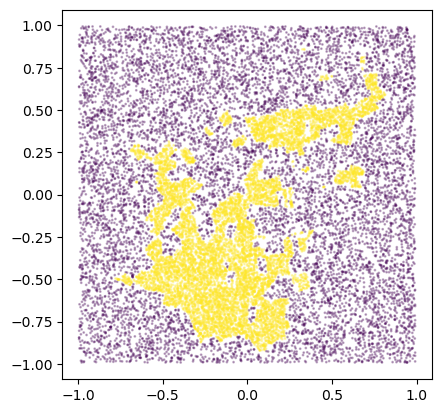

In [5]:
plt.scatter(X[:,0], X[:,1], c=y, s=1, alpha=0.3); plt.axis('square');

In [6]:
class BaarleNet(nn.Module):
    def __init__(self, hidden_layers=[64]):
        super(BaarleNet, self).__init__()
        layers = [nn.Linear(2, hidden_layers[0]), nn.ReLU()]
        for i in range(len(hidden_layers)-1):
            layers.append(nn.Linear(hidden_layers[i], hidden_layers[i+1]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_layers[-1], 2))
        self.layers=layers
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

## 3 Neurons

In [7]:
# num_neurons=3
# accuracies=[]
# for random_seed in range(1000):
#     torch.manual_seed(random_seed)  
    
#     X_tensor = torch.FloatTensor(X)
#     y_tensor = torch.tensor(y)
    
#     # Initialize model and optimizer
#     model = BaarleNet([num_neurons])
#     criterion = nn.CrossEntropyLoss()
#     # optimizer = optim.SGD(model.parameters(), lr=0.25)
#     optimizer = optim.Adam(model.parameters(), lr=0.01) #0.005
    
#     num_epochs = 10000
#     for epoch in range(num_epochs):
#         # Batch
#         #outputs = model(X_tensor)
#         #loss = criterion(outputs, y_tensor)
    
#         #Stochastic
#         outputs = model(torch.tensor(X[epoch%len(y)]).float())
#         loss = criterion(outputs, torch.tensor(y[epoch%len(y)])) 
    
#         #Worth trying minibatch?
        
#         # Backward and optimize
#         optimizer.zero_grad()
#         loss.backward()
    
#         # if epoch==307: break #Stop early here so weights don't get updated before we poke around
        
#         optimizer.step()

#     outputs_batch = model(X_tensor)
#     accuracy=(torch.argmax(outputs_batch, dim=1)==y_tensor).sum().item()/len(y)
#     if accuracy>0.85:
#         print(f'Seed [{random_seed}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')
#     accuracies.append(accuracies)

Seed [0], Loss: 0.1010, Accuracy: 0.8627
Seed [1], Loss: 0.1718, Accuracy: 0.8573
Seed [3], Loss: 0.3145, Accuracy: 0.8424
Seed [6], Loss: 0.4051, Accuracy: 0.8041
Seed [7], Loss: 0.4853, Accuracy: 0.8175
Seed [8], Loss: 0.3754, Accuracy: 0.8378
Seed [9], Loss: 0.1737, Accuracy: 0.8579
Seed [11], Loss: 0.1718, Accuracy: 0.8571
Seed [18], Loss: 0.3445, Accuracy: 0.8343
Seed [19], Loss: 0.3683, Accuracy: 0.8395
Seed [21], Loss: 0.1019, Accuracy: 0.8631
Seed [22], Loss: 0.3399, Accuracy: 0.8347
Seed [28], Loss: 0.3481, Accuracy: 0.8363
Seed [29], Loss: 0.2102, Accuracy: 0.8096
Seed [30], Loss: 0.5957, Accuracy: 0.8023
Seed [34], Loss: 0.2863, Accuracy: 0.8437
Seed [36], Loss: 0.3419, Accuracy: 0.8320
Seed [43], Loss: 0.2278, Accuracy: 0.8445
Seed [44], Loss: 0.1738, Accuracy: 0.8574
Seed [56], Loss: 0.1700, Accuracy: 0.8568
Seed [57], Loss: 0.1599, Accuracy: 0.8361
Seed [59], Loss: 0.4214, Accuracy: 0.8030
Seed [62], Loss: 0.3431, Accuracy: 0.8343
Seed [64], Loss: 0.2019, Accuracy: 0.8456

KeyboardInterrupt: 

In [ ]:
520, 204, 0

In [20]:
random_seed=520 #Random seed of 3 makes for a nice "fold down the edges" deal, wait that's for 2x2
num_neurons=3

torch.manual_seed(random_seed)  

X_tensor = torch.FloatTensor(X)
y_tensor = torch.tensor(y)

# Initialize model and optimizer
model = BaarleNet([num_neurons])
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.25)
optimizer = optim.Adam(model.parameters(), lr=0.01) #0.005

num_epochs = 10000
for epoch in range(num_epochs):
    # Batch
    #outputs = model(X_tensor)
    #loss = criterion(outputs, y_tensor)

    #Stochastic
    outputs = model(torch.tensor(X[epoch%len(y)]).float())
    loss = criterion(outputs, torch.tensor(y[epoch%len(y)])) 
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()

    # if epoch==307: break #Stop early here so weights don't get updated before we poke around
    
    optimizer.step()
    if (epoch+1) % (num_epochs//25) == 0:
        outputs_batch = model(X_tensor)
        accuracy=(torch.argmax(outputs_batch, dim=1)==y_tensor).sum().item()/len(y)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')


Epoch [400/10000], Loss: 0.9262, Accuracy: 0.6292
Epoch [800/10000], Loss: 0.4659, Accuracy: 0.6624
Epoch [1200/10000], Loss: 0.7797, Accuracy: 0.7171
Epoch [1600/10000], Loss: 0.3196, Accuracy: 0.7887
Epoch [2000/10000], Loss: 0.3407, Accuracy: 0.8410
Epoch [2400/10000], Loss: 1.4127, Accuracy: 0.8244
Epoch [2800/10000], Loss: 1.8348, Accuracy: 0.7688
Epoch [3200/10000], Loss: 0.0036, Accuracy: 0.8207
Epoch [3600/10000], Loss: 0.0576, Accuracy: 0.8335
Epoch [4000/10000], Loss: 0.4689, Accuracy: 0.8526
Epoch [4400/10000], Loss: 0.0003, Accuracy: 0.8163
Epoch [4800/10000], Loss: 0.3420, Accuracy: 0.8306
Epoch [5200/10000], Loss: 0.0000, Accuracy: 0.8368
Epoch [5600/10000], Loss: 0.2315, Accuracy: 0.8249
Epoch [6000/10000], Loss: 0.1179, Accuracy: 0.8378
Epoch [6400/10000], Loss: 0.0325, Accuracy: 0.8152
Epoch [6800/10000], Loss: 0.0660, Accuracy: 0.8652
Epoch [7200/10000], Loss: 0.1554, Accuracy: 0.8481
Epoch [7600/10000], Loss: 0.7112, Accuracy: 0.8521
Epoch [8000/10000], Loss: 1.9948,

In [21]:
probe=np.zeros((100,100,2))
for j, xx in enumerate(np.linspace(-1, 1, 100)):
    for k, yy in enumerate(np.linspace(-1, 1, 100)):
        probe[j, k]=[yy,xx]
probe=probe.reshape(100**2, -1)

h2 = model.model[:3](torch.tensor(probe).float())
h2 = h2.detach().numpy().reshape(100,100,2)

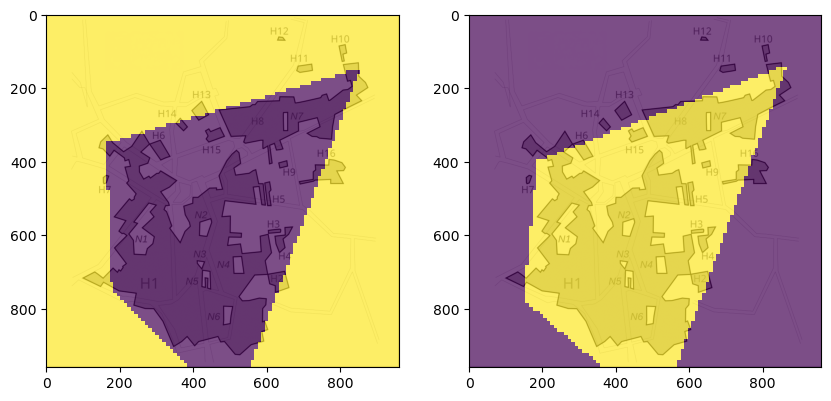

In [22]:
fig=plt.figure(0,(10,5)); 
for i in range(2):
    ax=fig.add_subplot(1,2,i+1)
    ax.imshow(map.mean(2), cmap='gray')
    ax.imshow(np.flipud(h2[:,:,i]>0), 
               extent=[0, 960, 960, 0],  # This maps to image coordinates
               alpha=0.7,
               cmap='viridis')
# plt.savefig(save_dir+str(num_neurons)+'/random_seed_'+str(random_seed)+'.png')

In [32]:
_=extract_weights_to_numpy(model)

import numpy as np

w1 = np.array([[-2.00458, 2.24611],
 [-2.56046, -1.21349],
 [-1.94774, 0.716835]], dtype=np.float32)
b1 = np.array([0.00728259, -1.38003, 1.77056], dtype=np.float32)
w2 = np.array([[2.46867, 3.78735, -1.90977],
 [-2.55351, -2.95687, 1.74294]], dtype=np.float32)
b2 = np.array([1.41342, -1.23457], dtype=np.float32)


In [33]:
model.model[0].weight

Parameter containing:
tensor([[-2.0046,  2.2461],
        [-2.5605, -1.2135],
        [-1.9477,  0.7168]], requires_grad=True)

In [34]:
model.model[2].weight

Parameter containing:
tensor([[ 2.4687,  3.7873, -1.9098],
        [-2.5535, -2.9569,  1.7429]], requires_grad=True)

## 4 Neurons


In [40]:
num_neurons=4
accuracies=[]
for random_seed in range(100):
    torch.manual_seed(random_seed)  
    
    X_tensor = torch.FloatTensor(X)
    y_tensor = torch.tensor(y)
    
    # Initialize model and optimizer
    model = BaarleNet([num_neurons])
    criterion = nn.CrossEntropyLoss()
    # optimizer = optim.SGD(model.parameters(), lr=0.25)
    optimizer = optim.Adam(model.parameters(), lr=0.01) #0.005
    
    num_epochs = 10000
    for epoch in range(num_epochs):
        # Batch
        #outputs = model(X_tensor)
        #loss = criterion(outputs, y_tensor)
    
        #Stochastic
        outputs = model(torch.tensor(X[epoch%len(y)]).float())
        loss = criterion(outputs, torch.tensor(y[epoch%len(y)])) 
    
        #Worth trying minibatch?
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
    
        # if epoch==307: break #Stop early here so weights don't get updated before we poke around
        
        optimizer.step()

    outputs_batch = model(X_tensor)
    accuracy=(torch.argmax(outputs_batch, dim=1)==y_tensor).sum().item()/len(y)
    if accuracy>0.85:
        print(f'Seed [{random_seed}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')
    accuracies.append(accuracy)

Seed [0], Loss: 0.1014, Accuracy: 0.8629
Seed [1], Loss: 0.2898, Accuracy: 0.8560
Seed [2], Loss: 0.1051, Accuracy: 0.8626
Seed [6], Loss: 0.0993, Accuracy: 0.8530
Seed [7], Loss: 0.1762, Accuracy: 0.8542
Seed [10], Loss: 0.2558, Accuracy: 0.8591
Seed [23], Loss: 0.0995, Accuracy: 0.8636
Seed [24], Loss: 0.0860, Accuracy: 0.8549
Seed [35], Loss: 0.1029, Accuracy: 0.8560
Seed [36], Loss: 0.1134, Accuracy: 0.8645
Seed [39], Loss: 0.1008, Accuracy: 0.8638
Seed [40], Loss: 0.1014, Accuracy: 0.8500
Seed [45], Loss: 0.1771, Accuracy: 0.8569
Seed [47], Loss: 0.2784, Accuracy: 0.8569
Seed [49], Loss: 0.0976, Accuracy: 0.8621
Seed [56], Loss: 0.1010, Accuracy: 0.8631
Seed [57], Loss: 0.0996, Accuracy: 0.8611
Seed [58], Loss: 0.3320, Accuracy: 0.8559
Seed [64], Loss: 0.1044, Accuracy: 0.8629
Seed [65], Loss: 0.0864, Accuracy: 0.8625
Seed [72], Loss: 0.2670, Accuracy: 0.8595
Seed [77], Loss: 0.1030, Accuracy: 0.8626
Seed [86], Loss: 0.2761, Accuracy: 0.8579
Seed [87], Loss: 0.0965, Accuracy: 0.86

In [41]:
np.argmax(accuracies)

36

In [42]:
accuracies[36]

0.86445

In [48]:
random_seed=36 #Random seed of 3 makes for a nice "fold down the edges" deal, wait that's for 2x2
num_neurons=4

torch.manual_seed(random_seed)  

X_tensor = torch.FloatTensor(X)
y_tensor = torch.tensor(y)

# Initialize model and optimizer
model = BaarleNet([num_neurons])
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.25)
optimizer = optim.Adam(model.parameters(), lr=0.01) #0.005

num_epochs = 10000
for epoch in range(num_epochs):
    # Batch
    #outputs = model(X_tensor)
    #loss = criterion(outputs, y_tensor)

    #Stochastic
    outputs = model(torch.tensor(X[epoch%len(y)]).float())
    loss = criterion(outputs, torch.tensor(y[epoch%len(y)])) 
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()

    # if epoch==307: break #Stop early here so weights don't get updated before we poke around
    
    optimizer.step()
    if (epoch+1) % (num_epochs//25) == 0:
        outputs_batch = model(X_tensor)
        accuracy=(torch.argmax(outputs_batch, dim=1)==y_tensor).sum().item()/len(y)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')


Epoch [400/10000], Loss: 1.0241, Accuracy: 0.6391
Epoch [800/10000], Loss: 0.4624, Accuracy: 0.6418
Epoch [1200/10000], Loss: 0.9557, Accuracy: 0.7266
Epoch [1600/10000], Loss: 0.4489, Accuracy: 0.7615
Epoch [2000/10000], Loss: 0.6871, Accuracy: 0.8203
Epoch [2400/10000], Loss: 1.7292, Accuracy: 0.8153
Epoch [2800/10000], Loss: 2.2713, Accuracy: 0.7666
Epoch [3200/10000], Loss: 0.0017, Accuracy: 0.8176
Epoch [3600/10000], Loss: 0.0351, Accuracy: 0.8249
Epoch [4000/10000], Loss: 0.2799, Accuracy: 0.8387
Epoch [4400/10000], Loss: 0.0002, Accuracy: 0.8047
Epoch [4800/10000], Loss: 0.3671, Accuracy: 0.8302
Epoch [5200/10000], Loss: 0.0000, Accuracy: 0.8470
Epoch [5600/10000], Loss: 0.3085, Accuracy: 0.8136
Epoch [6000/10000], Loss: 0.2255, Accuracy: 0.8199
Epoch [6400/10000], Loss: 0.0499, Accuracy: 0.8133
Epoch [6800/10000], Loss: 0.0843, Accuracy: 0.8619
Epoch [7200/10000], Loss: 0.2446, Accuracy: 0.8507
Epoch [7600/10000], Loss: 0.8312, Accuracy: 0.8470
Epoch [8000/10000], Loss: 1.8316,

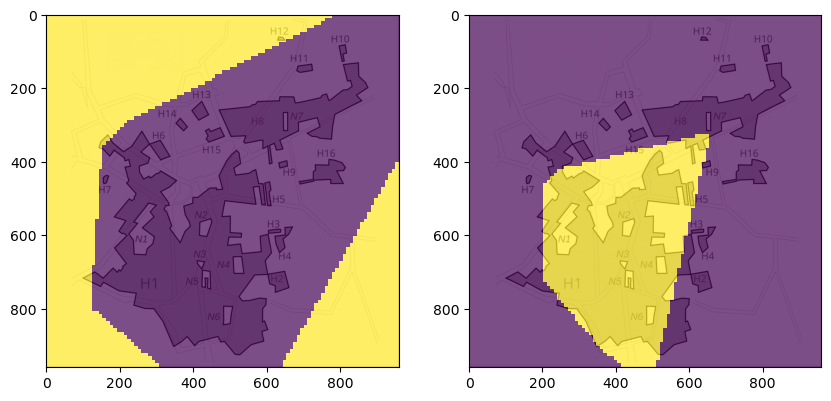

In [49]:
probe=np.zeros((100,100,2))
for j, xx in enumerate(np.linspace(-1, 1, 100)):
    for k, yy in enumerate(np.linspace(-1, 1, 100)):
        probe[j, k]=[yy,xx]
probe=probe.reshape(100**2, -1)

h2 = model.model[:3](torch.tensor(probe).float())
h2 = h2.detach().numpy().reshape(100,100,2)

fig=plt.figure(0,(10,5)); 
for i in range(2):
    ax=fig.add_subplot(1,2,i+1)
    ax.imshow(map.mean(2), cmap='gray')
    ax.imshow(np.flipud(h2[:,:,i]>0), 
               extent=[0, 960, 960, 0],  # This maps to image coordinates
               alpha=0.7,
               cmap='viridis')
# plt.savefig(save_dir+str(num_neurons)+'/random_seed_'+str(random_seed)+'.png')

In [50]:
_=extract_weights_to_numpy(model)

import numpy as np

w1 = np.array([[-1.8741, 2.12215],
 [-2.39381, -1.24014],
 [-0.940185, 1.40271],
 [2.04548, 0.489156]], dtype=np.float32)
b1 = np.array([-0.00892048, -1.32954, 1.71349, 0.940607], dtype=np.float32)
w2 = np.array([[2.56674, 2.26244, -1.40175, 0.737865],
 [-2.58904, -3.0681, 1.08007, -1.32219]], dtype=np.float32)
b2 = np.array([-0.852075, 0.492386], dtype=np.float32)


2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
2 12
2 13
2 14
2 15
2 16
2 17
2 18
2 19
2 20
2 21
2 22
2 23
2 24
2 25
2 26
2 27
2 28
2 29
2 30
2 31
2 32
2 33
2 34
2 35
2 36
2 37
2 38
2 39
2 40
2 41
2 42
2 43
2 44
2 45
2 46
2 47
2 48
2 49
2 50
2 51
2 52
2 53
2 54
2 55
2 56
2 57
2 58
2 59
2 60
2 61
2 62
2 63
2 64
2 65
2 66
2 67
2 68
2 69
2 70
2 71
2 72
2 73
2 74
2 75
2 76
2 77
2 78
2 79
2 80
2 81
2 82
2 83
2 84
2 85
2 86
2 87
2 88
2 89
2 90
2 91
2 92
2 93
2 94
2 95
2 96
2 97
2 98
2 99
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
3 10
3 11
3 12
3 13
3 14
3 15
3 16
3 17
3 18
3 19
3 20
3 21
3 22
3 23
3 24
3 25
3 26
3 27
3 28
3 29
3 30
3 31
3 32
3 33
3 34
3 35
3 36
3 37
3 38
3 39
3 40
3 41
3 42
3 43
3 44
3 45
3 46
3 47
3 48
3 49
3 50
3 51
3 52
3 53
3 54
3 55
3 56
3 57
3 58
3 59
3 60
3 61
3 62
3 63
3 64
3 65
3 66
3 67
3 68
3 69
3 70
3 71
3 72
3 73
3 74
3 75
3 76
3 77
3 78
3 79
3 80
3 81
3 82
3 83
3 84
3 85
3 86
3 87
3 88
3 89
3 90
3 91
3 92
3 93
3 94
3 95
3 96
3 97
3 98
3 99
4 0
4 1
4 2
4 3
4 4


<Figure size 640x480 with 0 Axes>

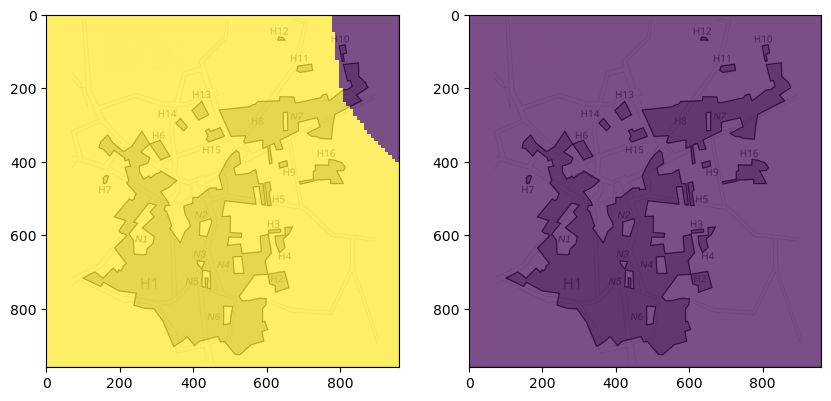

In [7]:
# save_dir='/Users/stephen/Stephencwelch Dropbox/welch_labs/backprop_3/hackin/jul_18_2/'

# for num_neurons in [2, 3, 4, 5, 8, 10]: 
#     os.makedirs(save_dir+str(num_neurons), exist_ok=True)
#     for random_seed in range(100):
#         for mode in ['stochastic']:
#             torch.manual_seed(random_seed)  
    
#             X_tensor = torch.FloatTensor(X)
#             y_tensor = torch.tensor(y)
            
#             model = BaarleNet([num_neurons])
#             criterion = nn.CrossEntropyLoss()
#             optimizer = optim.Adam(model.parameters(), lr=0.005) #0.005
            
#             num_epochs = 10000
#             for epoch in range(num_epochs):
#                 if mode == 'batch':
#                     outputs = model(X_tensor)
#                     loss = criterion(outputs, y_tensor)
#                 else:
#                     outputs = model(torch.tensor(X[epoch%len(y)]).float())
#                     loss = criterion(outputs, torch.tensor(y[epoch%len(y)])) 
    
#                 optimizer.zero_grad()
#                 loss.backward()
    
#             probe=np.zeros((100,100,2))
#             for j, xx in enumerate(np.linspace(-1, 1, 100)):
#                 for k, yy in enumerate(np.linspace(-1, 1, 100)):
#                     probe[j, k]=[yy,xx]
#             probe=probe.reshape(100**2, -1)
            
#             h2 = model.model[:3](torch.tensor(probe).float())
#             h2 = h2.detach().numpy().reshape(100,100,2)
    
#             plt.clf()
#             fig=plt.figure(0,(10,5)); 
#             for i in range(2):
#                 ax=fig.add_subplot(1,2,i+1)
#                 ax.imshow(map.mean(2), cmap='gray')
#                 ax.imshow(np.flipud(h2[:,:,i]>0), 
#                            extent=[0, 960, 960, 0],  # This maps to image coordinates
#                            alpha=0.7,
#                            cmap='viridis')
#             plt.savefig(save_dir+str(num_neurons)+'/random_seed_'+mode+'_'+str(random_seed)+'.png')
#             print(num_neurons, random_seed)

In [ ]:
save_dir='/Users/stephen/Stephencwelch Dropbox/welch_labs/backprop_3/hackin/jul_18_3/'

for num_neurons in [16, 32, 64, 128, 512, 1024, 10000]: 
    os.makedirs(save_dir+str(num_neurons), exist_ok=True)
    for random_seed in range(8):
        for mode in ['stochastic', 'batch']:
            torch.manual_seed(random_seed)  
    
            X_tensor = torch.FloatTensor(X)
            y_tensor = torch.tensor(y)
            
            model = BaarleNet([num_neurons])
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=0.001) #0.005
            
            num_epochs = 10000
            for epoch in range(num_epochs):
                if mode == 'batch':
                    outputs = model(X_tensor)
                    loss = criterion(outputs, y_tensor)
                else:
                    outputs = model(torch.tensor(X[epoch%len(y)]).float())
                    loss = criterion(outputs, torch.tensor(y[epoch%len(y)])) 
    
                optimizer.zero_grad()
                loss.backward()
    
            probe=np.zeros((100,100,2))
            for j, xx in enumerate(np.linspace(-1, 1, 100)):
                for k, yy in enumerate(np.linspace(-1, 1, 100)):
                    probe[j, k]=[yy,xx]
            probe=probe.reshape(100**2, -1)
            
            h2 = model.model[:3](torch.tensor(probe).float())
            h2 = h2.detach().numpy().reshape(100,100,2)
    
            plt.clf()
            fig=plt.figure(0,(10,5)); 
            for i in range(2):
                ax=fig.add_subplot(1,2,i+1)
                ax.imshow(map.mean(2), cmap='gray')
                ax.imshow(np.flipud(h2[:,:,i]>0), 
                           extent=[0, 960, 960, 0],  # This maps to image coordinates
                           alpha=0.7,
                           cmap='viridis')
            plt.savefig(save_dir+str(num_neurons)+'/random_seed_'+mode+'_'+str(random_seed)+'.png')
            print(num_neurons, random_seed)

16 0
16 0
16 1
16 1
16 2
16 2
16 3
16 3
16 4
16 4
16 5
16 5
16 6
16 6
16 7
16 7
32 0
32 0
32 1
32 1
32 2
32 2
32 3
32 3
32 4
32 4
32 5
32 5
32 6
32 6
32 7
32 7
64 0
64 0
64 1
64 1
64 2
64 2
64 3
64 3
64 4
64 4
64 5
64 5
64 6
64 6
64 7
64 7
128 0
128 0
128 1
128 1
128 2
128 2
128 3
128 3
128 4
128 4
128 5
128 5
128 6
128 6
128 7
128 7
512 0
512 0
512 1
512 1
512 2


In [ ]:
random_seed=0 #Random seed of 3 makes for a nice "fold down the edges" deal, wait that's for 2x2
torch.manual_seed(random_seed)  

X_tensor = torch.FloatTensor(X)
y_tensor = torch.tensor(y)

# Initialize model and optimizer
model = BaarleNet([num_neurons])
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.25)
optimizer = optim.Adam(model.parameters(), lr=0.001) #0.005

num_epochs = 10000
for epoch in range(num_epochs):
    # Batch
    outputs = model(X_tensor)
    loss = criterion(outputs, y_tensor)

    #Stochastic
    # outputs = model(torch.tensor(X[epoch%len(y)]).float())
    # loss = criterion(outputs, torch.tensor(y[epoch%len(y)])) 

    #Worth trying minibatch?
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()

    # if epoch==307: break #Stop early here so weights don't get updated before we poke around
    
    optimizer.step()
    if (epoch+1) % (num_epochs//25) == 0:
        outputs_batch = model(X_tensor)
        accuracy=(torch.argmax(outputs_batch, dim=1)==y_tensor).sum().item()/len(y)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')


In [ ]:
probe=np.zeros((100,100,2))
for j, xx in enumerate(np.linspace(-1, 1, 100)):
    for k, yy in enumerate(np.linspace(-1, 1, 100)):
        probe[j, k]=[yy,xx]
probe=probe.reshape(100**2, -1)

h2 = model.model[:3](torch.tensor(probe).float())
h2 = h2.detach().numpy().reshape(100,100,2)

In [ ]:
fig=plt.figure(0,(10,5)); 
for i in range(2):
    ax=fig.add_subplot(1,2,i+1)
    ax.imshow(map.mean(2), cmap='gray')
    ax.imshow(np.flipud(h2[:,:,i]>0), 
               extent=[0, 960, 960, 0],  # This maps to image coordinates
               alpha=0.7,
               cmap='viridis')
plt.savefig(save_dir+str(num_neurons)+'/random_seed_'+str(random_seed)+'.png')